In [2]:
### Use data from F5_1 to visualize lagged ligand target correlations and potential interactions

#############################################
# Prerequisites - Load Libraries

In [3]:
source('MS0_Libraries.r')

Warning message in read.table(file = file, header = header, sep = sep, quote = quote, :
“incomplete final line found by readTableHeader on '../conda_environment/Environment_Configs.csv'”


[1] "/home/icb/corinna.losert/miniconda3/envs/stark_stemi_R_Env_4_1//lib/R/library"



Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
   

In [4]:
source('MS4_Plot_Config.r')

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


###############################################
# Preqrequisites Configurations & Parameters

In [5]:
data_path =  '../data/current'

In [6]:
result_path ='../results/current'

In [7]:
data_path

[1] "../data/current"

In [8]:
### Decide which data to load from F5_1

In [9]:
name = 'V_FINAL'  # of dataset to load, prepared and combined data of E1 - skip E2 step 

In [10]:
weight_views = FALSE

In [11]:
### Version of the pre-processed data to load

In [12]:
mofa_name = 'V_FINAL_INTEGRATED'

In [13]:
filter_samples = 'acs'
#filter_samples = 'acs_w_o_infection_ccs'
#filter_samples = 'no_ccs_ccs'

# Load Data 

## Sample Data

In [14]:
path = paste0(result_path, '/00_Data_Overview/Merged_Sample_Meta_Data.csv')
sample_data = read.csv(path)
print(file.info(path)$mtime)

[1] "2023-12-10 11:16:00 CET"


## Prepared combined data

In [15]:
### Load pre-processed and combined data from E scripts

In [16]:
path = paste0(result_path, '/E-Analysis/Combined_Data_',name,'.csv')
data_long = read.csv(path)
print(path)
print(file.info(path)$mtime)

[1] "../results/current/E-Analysis/Combined_Data_V_FINAL.csv"
[1] "2024-01-03 14:22:52 CET"


In [17]:
head(data_long,2)

,X,sample_id,type,variable,value,config
,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>
1,1,k10,single_cell,X0_T.cell.CD4__SSU72,0.5896835,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-
2,2,k10,single_cell,X0_T.cell.CD4__PARK7,0.8587511,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-


In [18]:
nrow(data_long)

[1] 1557939

In [19]:
#### Filter based on selected samples

In [20]:
if(filter_samples == 'all'){
    filter = unique(sample_data$sample_id)
    }

if(filter_samples == 'acs'){
    filter = unique(sample_data$sample_id[sample_data$classification %in% c('acs_w_infection', 'acs_w_o_infection', 'acs_subacute')])
    }



if(filter_samples == 'acs_w_o_infection_ccs'){
    filter =unique(sample_data$sample_id[sample_data$classification %in% c('ccs', 'acs_w_o_infection')])
    
    }

if(filter_samples == 'no_ccs_ccs'){
    filter =unique(sample_data$sample_id[sample_data$classification %in% c('vollstaendiger_ausschluss','ccs','koronarsklerose')])
    
    }

In [21]:
length(filter)

[1] 112

In [22]:
nrow(data_long)

[1] 1557939

In [23]:
data_long = data_long[data_long$sample_id %in% filter,]

In [24]:
nrow(data_long)

[1] 1128736

In [25]:
### Also load completely normalized data (for violin plots)

In [26]:
path = paste0(result_path, '/E-Analysis/Combined_Data_',name,'_INTEGRATED', '.csv')
data_long_normalized = read.csv(path)
print(path)
print(file.info(path)$mtime)

[1] "../results/current/E-Analysis/Combined_Data_V_FINAL_INTEGRATED.csv"
[1] "2024-01-03 14:26:41 CET"


In [27]:
head(data_long_normalized,2)

,X,sample_id,variable,value,type
,<int>,<chr>,<chr>,<dbl>,<chr>
1,1,k1,CK,-2.397022,clinical_data
2,2,k10,CK,NA,clinical_data


## Nichenet data

In [28]:
# Load data from nichenet database about regulatory potential

In [29]:
ligand_target_matrix = readRDS(url("https://zenodo.org/record/3260758/files/ligand_target_matrix.rds"))  # gene-gene regulatory scores
# gives the regulatory potential of a target gene based on the ligand-tf & tf- target-gene links and weights of the signaling and gr network (multiply PPR of each ligand -tf  pair with the weights of the gr network)

In [30]:
### Generate data in long format

In [31]:
ligand_target_matrix_long = melt(ligand_target_matrix)

In [32]:
colnames(ligand_target_matrix_long) = c('target', 'ligand', 'regulatory_potential')

In [33]:
head(ligand_target_matrix_long,2)

,target,ligand,regulatory_potential
,<fct>,<fct>,<dbl>
1,A1BG,CXCL1,0.0003534343
2,A1BG-AS1,CXCL1,0.0001650894


## Prepared expression and correlation data

In [36]:
## Load data from F5_1 about lagged ligand- target correlations

In [37]:
name

[1] "V_FINAL"

In [38]:
load_path = paste0(result_path, '/F-Analysis/' ,'F4_Ligand_Target_Data', name,filter_samples, '.gz')
ligand_target_correlation = fread(load_path)
print(load_path)
print(file.info(load_path)$mtime)

Warning message in fread(load_path):
“Detected 12 column names but the data has 13 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


[1] "../results/current/F-Analysis/F4_Ligand_Target_DataV_FINALacs.gz"
[1] "2024-01-08 14:49:00 CET"


In [39]:
name

[1] "V_FINAL"

In [40]:
head(ligand_target_correlation,2)

V1,Ligand_Gene,Target_Gene,cluster,Ligand,Target,correlation,Target_Type,Ligand_Type,regulatory_potential,regulatory_potential_scaled,Target_Cell_Type,Ligand_Cell_Type
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,ADAM17,A1BG,proteomics,single_cell_0_X4_Monocytes...CD14__ADAM17,proteomics_0_A1BG_M0R009,0.08571429,proteomics,single_cell_0_X4_Monocytes...CD14,0.0004622894,0.01667641,proteomics,Monocytes...CD14
2,ADAM17,A1BG,proteomics,single_cell_0_X6_Monocytes...CD14__ADAM17,proteomics_0_A1BG_M0R009,-0.09713251,proteomics,single_cell_0_X6_Monocytes...CD14,0.0004622894,0.01667641,proteomics,Monocytes...CD14


In [41]:
###  Adjust to have nice cluster descriptions

In [42]:
ligand_target_correlation$Ligand_Cluster_Text = ligand_target_correlation$Ligand_Type
ligand_target_correlation$Target_Cluster_Text = ligand_target_correlation$Target_Type

In [43]:
ligand_target_correlation$Ligand_Cluster_Text = str_replace(ligand_target_correlation$Ligand_Cluster_Text , 'single_cell_0_X0_T.cell.CD4', 'CD4+ T cells (Cluster 0)')
ligand_target_correlation$Ligand_Cluster_Text = str_replace(ligand_target_correlation$Ligand_Cluster_Text , 'clinical_data', 'Clinical')
ligand_target_correlation$Ligand_Cluster_Text = str_replace(ligand_target_correlation$Ligand_Cluster_Text , 'single_cell_0_X1_T.cell.CD8', 'CD8+ T cells (Cluster 1)')
ligand_target_correlation$Ligand_Cluster_Text = str_replace(ligand_target_correlation$Ligand_Cluster_Text , 'single_cell_0_X10_B.cell', 'B cells (Cluster 10)')
ligand_target_correlation$Ligand_Cluster_Text = str_replace(ligand_target_correlation$Ligand_Cluster_Text , 'single_cell_0_X11_T.cell.CD4', 'CD4+ T cells (Cluster 11)')
ligand_target_correlation$Ligand_Cluster_Text = str_replace(ligand_target_correlation$Ligand_Cluster_Text , 'single_cell_0_X12_Monocytes...CD16_FCGR3A','FCGR3A(high) Monocytes (Cluster 12)')
ligand_target_correlation$Ligand_Cluster_Text = str_replace(ligand_target_correlation$Ligand_Cluster_Text , 'single_cell_0_X13_Dendritic',  'Dendritic cells (Cluster 13)')
ligand_target_correlation$Ligand_Cluster_Text= str_replace(ligand_target_correlation$Ligand_Cluster_Text , 'single_cell_0_X2_T.cell.CD4', 'CD4+ T cells (Cluster 2)')
ligand_target_correlation$Ligand_Cluster_Text = str_replace(ligand_target_correlation$Ligand_Cluster_Text , 'single_cell_0_X3_NK', 'NK cells (Cluster 3)')
ligand_target_correlation$Ligand_Cluster_Text = str_replace(ligand_target_correlation$Ligand_Cluster_Text , 'single_cell_0_X4_Monocytes...CD14', 'CD14(high) Monocytes (Cluster 4)')
ligand_target_correlation$Ligand_Cluster_Text = str_replace(ligand_target_correlation$Ligand_Cluster_Text , 'single_cell_0_X5_T.cell.CD4', 'CD4+ T cells (Cluster 5)')
ligand_target_correlation$Ligand_Cluster_Text = str_replace(ligand_target_correlation$Ligand_Cluster_Text , 'single_cell_0_X6_Monocytes...CD14','CD14(high) Monocytes (Cluster 6)')
ligand_target_correlation$Ligand_Cluster_Text = str_replace(ligand_target_correlation$Ligand_Cluster_Text , 'single_cell_0_X7_Monocytes...CD14', 'CD14(high) Monocytes (Cluster 7)')
ligand_target_correlation$Ligand_Cluster_Text = str_replace(ligand_target_correlation$Ligand_Cluster_Text , 'single_cell_0_X8_B.cell','B cells (Cluster 8)')
ligand_target_correlation$Ligand_Cluster_Text = str_replace(ligand_target_correlation$Ligand_Cluster_Text , 'single_cell_0_X9_Monocytes...CD16_FCGR3A','FCGR3A(high) Monocytes (Cluster 9)')

ligand_target_correlation$Ligand_Cluster_Text  = str_replace(ligand_target_correlation$Ligand_Cluster_Text  , 'clinical','Clinical')
ligand_target_correlation$Ligand_Cluster_Text  = str_replace(ligand_target_correlation$Ligand_Cluster_Text  , 'cytokine','Cytokine')
ligand_target_correlation$Ligand_Cluster_Text  = str_replace(ligand_target_correlation$Ligand_Cluster_Text  , 'neutrophil','Neutrophil')
ligand_target_correlation$Ligand_Cluster_Text = str_replace(ligand_target_correlation$Ligand_Cluster_Text  , 'proteomics','Proteomics')

In [44]:
ligand_target_correlation$Target_Cluster_Text = str_replace(ligand_target_correlation$Target_Cluster_Text , 'single_cell_0_X0_T.cell.CD4', 'CD4+ T cells (Cluster 0)')
ligand_target_correlation$Target_Cluster_Text = str_replace(ligand_target_correlation$Target_Cluster_Text , 'clinical_data', 'Clinical')
ligand_target_correlation$Target_Cluster_Text = str_replace(ligand_target_correlation$Target_Cluster_Text , 'single_cell_0_X1_T.cell.CD8', 'CD8+ T cells (Cluster 1)')
ligand_target_correlation$Target_Cluster_Text = str_replace(ligand_target_correlation$Target_Cluster_Text , 'single_cell_0_X10_B.cell', 'B cells (Cluster 10)')
ligand_target_correlation$Target_Cluster_Text = str_replace(ligand_target_correlation$Target_Cluster_Text , 'single_cell_0_X11_T.cell.CD4', 'CD4+ T cells (Cluster 11)')
ligand_target_correlation$Target_Cluster_Text = str_replace(ligand_target_correlation$Target_Cluster_Text , 'single_cell_0_X12_Monocytes...CD16_FCGR3A','FCGR3A(high) Monocytes (Cluster 12)')
ligand_target_correlation$Target_Cluster_Text = str_replace(ligand_target_correlation$Target_Cluster_Text , 'single_cell_0_X13_Dendritic',  'Dendritic cells (Cluster 13)')
ligand_target_correlation$Target_Cluster_Text= str_replace(ligand_target_correlation$Target_Cluster_Text , 'single_cell_0_X2_T.cell.CD4', 'CD4+ T cells (Cluster 2)')
ligand_target_correlation$Target_Cluster_Text = str_replace(ligand_target_correlation$Target_Cluster_Text , 'single_cell_0_X3_NK', 'NK cells (Cluster 3)')
ligand_target_correlation$Target_Cluster_Text = str_replace(ligand_target_correlation$Target_Cluster_Text , 'single_cell_0_X4_Monocytes...CD14', 'CD14(high) Monocytes (Cluster 4)')
ligand_target_correlation$Target_Cluster_Text = str_replace(ligand_target_correlation$Target_Cluster_Text , 'single_cell_0_X5_T.cell.CD4', 'CD4+ T cells (Cluster 5)')
ligand_target_correlation$Target_Cluster_Text = str_replace(ligand_target_correlation$Target_Cluster_Text , 'single_cell_0_X6_Monocytes...CD14','CD14(high) Monocytes (Cluster 6)')
ligand_target_correlation$Target_Cluster_Text = str_replace(ligand_target_correlation$Target_Cluster_Text , 'single_cell_0_X7_Monocytes...CD14', 'CD14(high) Monocytes (Cluster 7)')
ligand_target_correlation$Target_Cluster_Text = str_replace(ligand_target_correlation$Target_Cluster_Text , 'single_cell_0_X8_B.cell','B cells (Cluster 8)')
ligand_target_correlation$Target_Cluster_Text = str_replace(ligand_target_correlation$Target_Cluster_Text , 'single_cell_0_X9_Monocytes...CD16_FCGR3A','FCGR3A(high) Monocytes (Cluster 9)')

ligand_target_correlation$Target_Cluster_Text  = str_replace(ligand_target_correlation$Target_Cluster_Text  , 'clinical','Clinical')
ligand_target_correlation$Target_Cluster_Text  = str_replace(ligand_target_correlation$Target_Cluster_Text  , 'cytokine','Cytokine')
ligand_target_correlation$Target_Cluster_Text  = str_replace(ligand_target_correlation$Target_Cluster_Text  , 'neutrophil','Neutrophil')
ligand_target_correlation$Target_Cluster_Text = str_replace(ligand_target_correlation$Target_Cluster_Text  , 'proteomics','Proteomics')

In [45]:
unique(ligand_target_correlation$Ligand_Cluster_Text)

[1] "CD14(high) Monocytes (Cluster 4)"    "CD14(high) Monocytes (Cluster 6)"   
 [3] "Neutrophil"                          "CD8+ T cells (Cluster 1)"           
 [5] "CD4+ T cells (Cluster 11)"           "CD4+ T cells (Cluster 5)"           
 [7] "CD14(high) Monocytes (Cluster 7)"    "CD4+ T cells (Cluster 0)"           
 [9] "NK cells (Cluster 3)"                "CD4+ T cells (Cluster 2)"           
[11] "Dendritic cells (Cluster 13)"        "FCGR3A(high) Monocytes (Cluster 12)"
[13] "FCGR3A(high) Monocytes (Cluster 9)"  "B cells (Cluster 10)"               
[15] "B cells (Cluster 8)"                 "Cytokine"

In [46]:
unique(ligand_target_correlation$Target_Cluster_Text)

[1] "Proteomics"                          "CD4+ T cells (Cluster 11)"          
 [3] "CD4+ T cells (Cluster 0)"            "CD4+ T cells (Cluster 2)"           
 [5] "CD8+ T cells (Cluster 1)"            "B cells (Cluster 10)"               
 [7] "NK cells (Cluster 3)"                "FCGR3A(high) Monocytes (Cluster 12)"
 [9] "CD4+ T cells (Cluster 5)"            "Neutrophil"                         
[11] "FCGR3A(high) Monocytes (Cluster 9)"  "B cells (Cluster 8)"                
[13] "Dendritic cells (Cluster 13)"        "Clinical"                           
[15] "CD14(high) Monocytes (Cluster 4)"    "CD14(high) Monocytes (Cluster 6)"   
[17] "CD14(high) Monocytes (Cluster 7)"

In [47]:
### Extract cluster numbers

In [48]:
ligand_target_correlation$Ligand_Cluster_Number = str_replace_all(ligand_target_correlation$Ligand_Cluster_Text, '.*Cluster |\\)', '')
ligand_target_correlation$Target_Cluster_Number = str_replace_all(ligand_target_correlation$Target_Cluster_Text, '.*Cluster |\\)', '')

In [49]:
unique(ligand_target_correlation$Target_Cluster_Number)

[1] "Proteomics" "11"         "0"          "2"          "1"         
 [6] "10"         "3"          "12"         "5"          "Neutrophil"
[11] "9"          "8"          "13"         "Clinical"   "4"         
[16] "6"          "7"

In [50]:
### Extract Cell-Types without Cluster

In [51]:
ligand_target_correlation$Ligand_Cell_Type = str_replace_all(ligand_target_correlation$Ligand_Cluster_Text, ' \\(Cluster.*', '')
ligand_target_correlation$Target_Cell_Type = str_replace_all(ligand_target_correlation$Target_Cluster_Text, ' \\(Cluster.*', '')

In [52]:
unique(ligand_target_correlation$Ligand_Cell_Type )

[1] "CD14(high) Monocytes"   "Neutrophil"             "CD8+ T cells"          
[4] "CD4+ T cells"           "NK cells"               "Dendritic cells"       
[7] "FCGR3A(high) Monocytes" "B cells"                "Cytokine"

## Load MOFA model and extract weight data

In [53]:
model_name = paste0("MOFA_MODEL", mofa_name, '-', weight_views, '.hdf5')

In [54]:
model_name

[1] "MOFA_MODELV_FINAL_INTEGRATED-FALSE.hdf5"

In [55]:
outfile = file.path( paste0(result_path, '/E-Analysis/',  model_name) )

In [56]:
print(file.info(outfile)$mtime)

[1] "2024-01-03 14:33:17 CET"


In [57]:
outfile

[1] "../results/current/E-Analysis/MOFA_MODELV_FINAL_INTEGRATED-FALSE.hdf5"

In [58]:
model <- load_model(outfile)

Warning message in .quality_control(object, verbose = verbose):
“Factor(s) 9, 12, 17 are strongly correlated with the total number of expressed features for at least one of your omics. Such factors appear when there are differences in the total 'levels' between your samples, *sometimes* because of poor normalisation in the preprocessing steps.
”


In [60]:
### Extract weight data

In [61]:
weights = get_weights(model, views = "all", factors = "all")

In [62]:
weight_data = data.frame()

In [63]:
for (i in names(weights)){
    data = data.frame(weights[[i]])
    data$type = i
    weight_data = rbind(weight_data,data)
    }

In [64]:
weight_data$variable_name = rownames(weight_data)

In [65]:
head(weight_data,2)

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,⋯,Factor13,Factor14,Factor15,Factor16,Factor17,Factor18,Factor19,Factor20,type,variable_name
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
CK,-0.13418597,0.4019222,-0.1010765,-0.002177566,-0.5093667,0.24179134,-0.03635097,0.05304519,0.0011574664,-0.012307130,⋯,-0.1604505,-0.001418618,0.1540945,0.003821864,-0.24205661,0.004092582,-0.0005618720,-0.2423944,clinical_data,CK
CK_MB,-0.06222621,0.2731985,-0.2000362,-0.076098327,-0.1439445,0.04289833,-0.71818597,0.18658970,-0.0007753517,-0.003074308,⋯,-0.6107162,0.002499494,0.3864464,-0.001090137,-0.08311704,0.009503498,-0.0003621744,0.2060158,clinical_data,CK_MB


In [66]:
### Prepare feature weight in long format

In [67]:
feature_weights = weight_data

In [68]:
feature_weights$type_cluster = weight_data$type

In [69]:
feature_weights$type[!feature_weights$type %in% c('clinical_data', 'cytokine', 'neutrophil', 'proteomics')] = 'single_cell'

In [70]:
feature_weights$variable_name_conc = paste0(feature_weights$type, '_0_', feature_weights$variable_name)

In [71]:
feature_weights_long = melt(feature_weights) 

Using type, variable_name, type_cluster, variable_name_conc as id variables



In [72]:
head(feature_weights_long,2)

,type,variable_name,type_cluster,variable_name_conc,variable,value
,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>
1,clinical_data,CK,clinical_data,clinical_data_0_CK,Factor1,-0.13418597
2,clinical_data,CK_MB,clinical_data,clinical_data_0_CK_MB,Factor1,-0.06222621


In [73]:
### based on feature - weights long calculate amount of features per dimension

In [74]:
amount_features_per_dimension = feature_weights_long[feature_weights_long$variable == 'Factor1',] %>% group_by(type_cluster) %>% count()

In [75]:
colnames(amount_features_per_dimension) = c('type_cluster', 'amount_features')

In [76]:
head(amount_features_per_dimension,2)

type_cluster,amount_features
<chr>,<int>
X0_TcellCD4,688
X10_Bcell,796


In [77]:
amount_features_per_dimension = merge(amount_features_per_dimension, amount_features_per_dimension, by = NULL)

In [78]:
amount_features_per_dimension$combined_amount = amount_features_per_dimension$amount_features.x * amount_features_per_dimension$amount_features.y

In [79]:
amount_features_per_dimension$amount_features.y = NULL
amount_features_per_dimension$amount_features.x = NULL

In [80]:
colnames(amount_features_per_dimension) = c('Ligand_Type', 'Target_Type', 'combined_amount_features')

# Visualize Ligand Target Correlations

## Circoplot Visualization

### Factor specific - highest ligand target correlations

In [174]:
## define correlations that should be visualized (here ligand- target; alternative: ligand-receptor)
data_vis = ligand_target_correlation

In [175]:
## round correlations
data_vis$correlation = round(data_vis$correlation,2)

#### Parameters for visualization

In [176]:
head(data_vis,2)

V1,Ligand_Gene,Target_Gene,cluster,Ligand,Target,correlation,Target_Type,Ligand_Type,regulatory_potential,regulatory_potential_scaled,Target_Cell_Type,Ligand_Cell_Type,Ligand_Cluster_Text,Target_Cluster_Text,Ligand_Cluster_Number,Target_Cluster_Number
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ADAM17,A1BG,proteomics,single_cell_0_X4_Monocytes...CD14__ADAM17,proteomics_0_A1BG_M0R009,0.09,proteomics,single_cell_0_X4_Monocytes...CD14,0.0004622894,0.01667641,Proteomics,CD14(high) Monocytes,CD14(high) Monocytes (Cluster 4),Proteomics,4,Proteomics
2,ADAM17,A1BG,proteomics,single_cell_0_X6_Monocytes...CD14__ADAM17,proteomics_0_A1BG_M0R009,-0.10,proteomics,single_cell_0_X6_Monocytes...CD14,0.0004622894,0.01667641,Proteomics,CD14(high) Monocytes,CD14(high) Monocytes (Cluster 6),Proteomics,6,Proteomics


In [177]:
#### Set figure name
figure_name = 'SUPP11_Lagged_Circo'

In [178]:
### Define which ligand target correlations to show based on regulatory potential score
use_thres = 'quant_new'# alternative 'percent' , 'quant_new', 'quant' -> defines which of the parameters below is used to filter
reg_pot_thres_var = '95%'  #  use_thres = 'quant': top x% of regulatory potential scores of input data --> ! dependent on input data
lig_thres = 0.1   #  use_thres ='percent': top percentage of targets per ligand --> all ligands same amount of targets
reg_pot_quant = '97.0%' #  use_thres = quant_new: select on complete regulatory potential scores the top x%


In [179]:
### Define on whether to select top ligands or top targets of Factor 2
top_selection = 'top_ligands' # alternatives: 'top_ligands'; 'top_targets'

In [180]:
### select a regulatory potential threshold based on parameter above

if(use_thres == 'quant'){
    reg_pot_thres = quantile(data_vis$regulatory_potential, probs = seq(0, 1, 0.001))[reg_pot_thres_var]
    top_targets_per_ligand = ligand_target_matrix_long[ligand_target_matrix_long$regulatory_potential > reg_pot_thres,]
    }

if(use_thres == 'percent'){
    top_targets_per_ligand = ligand_target_matrix_long[ligand_target_matrix_long$regulatory_potential > 0,]  %>% group_by(ligand) %>% arrange( desc(regulatory_potential),  .by_group = TRUE)  %>% top_frac(lig_thres)
    }

if(use_thres == 'quant_new'){
    reg_pot_thres = quantile(ligand_target_matrix_long$regulatory_potential, probs = seq(0, 1, 0.001))[reg_pot_quant]
    top_targets_per_ligand = ligand_target_matrix_long[ligand_target_matrix_long$regulatory_potential > reg_pot_thres,]
    }


In [181]:
### select a correlation threshold; which correlations will be shown (all lower correlations will be filtered out)
cor_thres = 0.4

In [182]:
### Select the MOFA factor and the percentage of top features on the factor that should be selected
top_variable_fraction = 0.025
geneset_oi_selection = 'positive' # alternatives: 'positive', 'negative', 'all' --> decide on which features take as targets
factor = 'Factor2'
filter_factor = TRUE

# change the Factor to generate Factor-specific plots of publications

In [183]:
### Filter only on a specific cell-type as target
filter_cell_type = FALSE # or add cell-type to filter fore

In [184]:
### Define variable that should show interaction-sizes 

In [185]:
#data_vis$interaction_size = abs(data_vis$correlation)
data_vis$interaction_size = data_vis$regulatory_potential_scaled

#### Prepare data

In [186]:
### Filter based on correlation threshold

In [187]:
data_vis = data_vis[abs(data_vis$correlation) >= cor_thres,]

In [188]:
# Filter on selected targets for ligand based on regulatory potential score
data_vis = merge(data_vis, top_targets_per_ligand, by.x = c('Ligand_Gene', 'Target_Gene'), by.y = c('ligand', 'target'))


In [189]:
#### Filter on selected top genes of MOFA factor

## Select geneset OI
geneset_oi_pos_per_factor = feature_weights_long %>% group_by(variable) %>% arrange( desc(value),  .by_group = TRUE)  %>% top_frac(top_variable_fraction)
geneset_oi_pos_per_factor$direction = 'positive'

geneset_oi_neg_per_factor = feature_weights_long %>% group_by(variable) %>% arrange(desc(value),  .by_group = TRUE)  %>% top_frac(-top_variable_fraction)
geneset_oi_neg_per_factor$direction = 'negative'

if(geneset_oi_selection == 'all'){
    geneset_oi = rbind(geneset_oi_pos_per_factor, geneset_oi_neg_per_factor)
    }
if(geneset_oi_selection == 'positive'){
    geneset_oi = geneset_oi_pos_per_factor
    }
if(geneset_oi_selection == 'negative'){
    geneset_oi = geneset_oi_neg_per_factor
    }

geneset_oi = geneset_oi[geneset_oi$variable == factor,]

nrow(geneset_oi)

if(filter_cell_type != FALSE){
    geneset_oi = geneset_oi[geneset_oi$type_cluster %in% filter_cell_type,]
    }

if(filter_factor == TRUE){
    if(top_selection == 'top_ligands'){
        data_vis = data_vis[(data_vis$Ligand %in% unique(geneset_oi$variable_name_conc)),] ## ! only filtered on ligand not TARGET
        }
    if(top_selection == 'top_targets'){
        data_vis = data_vis[(data_vis$Target %in% unique(geneset_oi$variable_name_conc)),] ## ! only filtered on Target
        
        }
     }
    

Selecting by value
Selecting by value


[1] 332

In [190]:
## Add factor values to the data (use original feature weights instead of filtered geneset_oi to also add weights for ligands that are not among top genes)

In [191]:
factor_value_merge = feature_weights_long[feature_weights_long$variable == factor,][,c('variable_name_conc', 'value')]

In [192]:
## Add for ligands

In [193]:
colnames(factor_value_merge) = c('Ligand', 'Ligand_factor_weight')

In [194]:
head(factor_value_merge,2)

,Ligand,Ligand_factor_weight
,<chr>,<dbl>
13283,clinical_data_0_CK,0.4019222
13284,clinical_data_0_CK_MB,0.2731985


In [195]:
data_vis = merge(data_vis, factor_value_merge,by = 'Ligand',  all.x = TRUE)

In [196]:
## Add for Targets

In [197]:
colnames(factor_value_merge) = c('Target', 'Target_factor_weight')

In [198]:
data_vis = merge(data_vis, factor_value_merge, by = 'Target', all.x = TRUE)

In [199]:
head(data_vis,2)

Target,Ligand,Ligand_Gene,Target_Gene,V1,cluster,correlation,Target_Type,Ligand_Type,regulatory_potential.x,⋯,Target_Cell_Type,Ligand_Cell_Type,Ligand_Cluster_Text,Target_Cluster_Text,Ligand_Cluster_Number,Target_Cluster_Number,interaction_size,regulatory_potential.y,Ligand_factor_weight,Target_factor_weight
<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<dbl>,<chr>,<chr>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
clinical_data_0_CRP,cytokine_0_IL6__IL6,IL6,CRP,2159962,clinical_data,0.77,clinical_data,cytokine,0.008810596,⋯,Clinical,Cytokine,Cytokine,Clinical,Cytokine,Clinical,0.31782920,0.008810596,0.3653240,0.14369327
neutrophil_0_ABHD2,single_cell_0_X0_T.cell.CD4__HMGB1,HMGB1,ABHD2,1284506,neutrophil,-0.43,neutrophil,single_cell_0_X0_T.cell.CD4,0.001569261,⋯,Neutrophil,CD4+ T cells,CD4+ T cells (Cluster 0),Neutrophil,0,Neutrophil,0.05660876,0.001569261,0.4907236,-0.08493788


In [200]:
length(unique(data_vis$Ligand))

[1] 8

In [201]:
length(unique(data_vis$Target))

[1] 84

#### Prepare plotting

In [202]:
## Convert proteomics ligand/target format
data_vis$Target_Gene[data_vis$Target_Cell_Type == 'Proteomics'] = str_replace(data_vis$Target[data_vis$Target_Cell_Type == 'Proteomics'], 'proteomics_0_', '')
data_vis$Ligand_Gene[data_vis$Ligand_Cell_Type == 'Proteomics'] = str_replace(data_vis$Ligand[data_vis$Ligand_Cell_Type == 'Proteomics'], 'proteomics_0_', '')

In [203]:
data_vis$Target_Cluster_Number  = str_replace(data_vis$Target_Cluster_Number, 'Proteomics', 'P')
data_vis$Ligand_Cluster_Number = str_replace(data_vis$Ligand_Cluster_Number, 'Proteomics', 'P')

data_vis$Target_Cluster_Number  = str_replace(data_vis$Target_Cluster_Number, 'Neutrophil', 'N')
data_vis$Ligand_Cluster_Number = str_replace(data_vis$Ligand_Cluster_Number, 'Neutrophil', 'N')

data_vis$Target_Cluster_Number  = str_replace(data_vis$Target_Cluster_Number, 'Cytokine', 'CY')
data_vis$Ligand_Cluster_Number = str_replace(data_vis$Ligand_Cluster_Number, 'Cytokine', 'CY')

data_vis$Target_Cluster_Number  = str_replace(data_vis$Target_Cluster_Number, 'Clinical', 'CL')
data_vis$Ligand_Cluster_Number = str_replace(data_vis$Ligand_Cluster_Number, 'Clinical', 'CL')

In [204]:
### Define variable that defines ticks --> dimension/ segments shown
### should be the smallest unit (currently genes)
data_vis$plot_var = data_vis$Ligand
data_vis$plot_var_R = data_vis$Target

In [205]:
### Aggregate by defined variables (on this level probably not necessary)

In [206]:
data_vis = data_vis %>% group_by(
    plot_var, plot_var_R, # Variables for segement definition (smallest unit)
    Ligand_Type, Target_Type, Ligand_Cell_Type, Target_Cell_Type,  # Variables for color definition (based on cell-types currently)
    Ligand_Gene, Target_Gene, Ligand_factor_weight, Target_factor_weight, # Variables for text description 
    Ligand_Cluster_Text, Target_Cluster_Text, 
    Ligand_Cluster_Number, Target_Cluster_Number) %>% summarise (
    interaction_size = sum(interaction_size) , # Aggregate variable for segment size
    weight = mean(abs(correlation)), # Aggregate variable for transparency
    correlation = mean(correlation) # variable for potentially changing color
)  

`summarise()` has grouped output by 'plot_var', 'plot_var_R', 'Ligand_Type',
'Target_Type', 'Ligand_Cell_Type', 'Target_Cell_Type', 'Ligand_Gene',
'Target_Gene', 'Ligand_factor_weight', 'Target_factor_weight',
'Ligand_Cluster_Text', 'Target_Cluster_Text', 'Ligand_Cluster_Number'. You can
override using the `.groups` argument.


In [207]:
### Define links and order

In [208]:
## Define how to order ligands
ordered_data_sender = data_vis %>% arrange(Ligand_Cell_Type,
                                           Ligand_Gene, 
                                           Ligand_Cluster_Number, 
                                           Target_Cell_Type, 
                                           Target_Cluster_Number)

In [209]:
## Define how to order targets
ordered_data_receiver = data_vis %>% arrange(Target_Cell_Type, 
                                             Target_Gene, 
                                             Target_Cluster_Number, 
                                             Ligand_Cell_Type, 
                                             Ligand_Cluster_Number)

In [210]:
order = c(ordered_data_sender$plot_var, ordered_data_receiver$plot_var_R)

In [211]:
## Order data_vis dataset

In [212]:
data_vis = ordered_data_sender

In [213]:
links_circle = data_vis[,c('plot_var', 'plot_var_R', 'interaction_size')]
colnames(links_circle) = c('ligand' , 'target', 'weight')

In [214]:
## Define Color Scheme

In [215]:
color_scheme = data.frame(
    color = c("#3c75af",
             "#e1833d",
             "#4e9b6d",
             "#c43b36",
             "#6d5296",
             "#845950",
             "#c67dac",
             "#b6bc6d",
             "#59b4c6",
             "#b1c5e4",
             "#efbc82",
             "#a5c88e",
             "#e69998",
              "#c0b0d2",
             "#330FED",
             "#07580A",
             "#9F8918",
             "#128890"),
    cluster = c( "CD4+ T cells (Cluster 0)",  
                "CD8+ T cells (Cluster 1)",
                "CD4+ T cells (Cluster 2)" ,
                "NK cells (Cluster 3)",
               "CD14(high) Monocytes (Cluster 4)",
               "CD4+ T cells (Cluster 5)",
               "CD14(high) Monocytes (Cluster 6)",
               "CD14(high) Monocytes (Cluster 7)",
               "B cells (Cluster 8)" ,
               "FCGR3A(high) Monocytes (Cluster 9)",
               "B cells (Cluster 10)",
               "CD4+ T cells (Cluster 11)" ,
               "FCGR3A(high) Monocytes (Cluster 12)",
               "Dendritic cells (Cluster 13)" ,
               "Clinical",
               "Cytokine",
               "Neutrophil",
               "Proteomics"))

In [216]:
color_scheme$color_R = color_scheme$color

In [217]:
nrow(data_vis)

[1] 85

In [218]:
data_vis = left_join(data_vis, color_scheme[,c('cluster', 'color')], by = c('Ligand_Cluster_Text' = 'cluster'))

In [219]:
data_vis = left_join(data_vis, color_scheme[,c('cluster', 'color_R')], by = c('Target_Cluster_Text'= 'cluster'))

In [220]:
nrow(data_vis)

[1] 85

In [221]:
grid_col =data_vis[,c('color', 'color_R')]

In [222]:
ligand_color = data_vis %>% distinct(plot_var,color)
grid_ligand_color = ligand_color$color %>% set_names(ligand_color$plot_var)
target_color = data_vis %>% distinct(plot_var_R,color_R)
grid_target_color = target_color$color_R %>% set_names(target_color$plot_var_R)

grid_col =c(grid_ligand_color,grid_target_color)

In [223]:
#### Adjust text descriptions

In [224]:
text = rbind(data.frame(variable = data_vis$plot_var, text = paste0(data_vis$Ligand_Gene, ' (', data_vis$Ligand_Cluster_Number, ')' ) ), 
             data.frame(variable = data_vis$plot_var_R, text = paste0(data_vis$Target_Gene, ' (', data_vis$Target_Cluster_Number, ')' )))

In [225]:
### Define Legend

In [226]:
lgd1 = Legend(at = unique(c(unique(data_vis$Ligand_Cluster_Text), unique(data_vis$Target_Cluster_Text))), type = "points", 
              labels_gp = gpar(fontsize = 20),
              grid_height = unit(10, "mm"), grid_width = unit(4, "mm"), gap = unit(4, "mm"),
              legend_gp =list(col = unique(c(unique(data_vis$color), unique(data_vis$color_R)))), 
              title_position = "topleft", 
              title = "View", 
              title_gp = gpar(fontsize = 20),
              pch = 16, 
              size = unit(8, "mm"))

In [227]:
lgd_list_vertical = packLegend(lgd1)

In [228]:
### Color for Links based on correlation

In [229]:
## highlight selected connections mentioned in manuscript

In [230]:
highlighting_factor2 = data.frame(plot_var = c('cytokine_0_IL6__IL6',
                                       'cytokine_0_IL6__IL6', 
                                       'cytokine_0_IL6__IL6',
                                                'cytokine_0_IL6__IL6',
                                      'single_cell_0_X0_T.cell.CD4__HMGB1',
                                      'single_cell_0_X1_T.cell.CD8__HMGB1',
                                      'single_cell_0_X1_T.cell.CD8__HMGB1',
                                      'single_cell_0_X0_T.cell.CD4__HMGB1',
                                      'single_cell_0_X0_T.cell.CD4__HMGB1',
                                      'single_cell_0_X0_T.cell.CD4__HMGB1',
                                              'single_cell_0_X2_T.cell.CD4__HMGB1',
                                              'single_cell_0_X2_T.cell.CD4__HMGB1',
                                              'single_cell_0_X2_T.cell.CD4__HMGB1',
                                              'single_cell_0_X1_T.cell.CD8__HMGB1',
                                              'single_cell_0_X1_T.cell.CD8__TGFB1',
                                              'single_cell_0_X1_T.cell.CD8__TGFB1'),
                          plot_var_R = c( 'single_cell_0_X4_Monocytes...CD14__PIM1',
                                         'single_cell_0_X7_Monocytes...CD14__VCAN', 
                                         'single_cell_0_X7_Monocytes...CD14__CD74',
                                          'single_cell_0_X4_Monocytes...CD14__CD74',
                                        'single_cell_0_X1_T.cell.CD8__UBC',
                                        'single_cell_0_X0_T.cell.CD4__UBC',
                                        'single_cell_0_X2_T.cell.CD4__UBC',
                                        'single_cell_0_X4_Monocytes...CD14__PSME2',
                                        'single_cell_0_X6_Monocytes...CD14__PSME2',
                                        'single_cell_0_X7_Monocytes...CD14__PSME2',
                                        'single_cell_0_X4_Monocytes...CD14__PSME2',
                                        'single_cell_0_X6_Monocytes...CD14__PSME2',
                                        'single_cell_0_X7_Monocytes...CD14__PSME2',
                                        'single_cell_0_X4_Monocytes...CD14__PSME2',
                                         'single_cell_0_X4_Monocytes...CD14__ODC1',
                                         'single_cell_0_X0_T.cell.CD4__ODC1'
                                 ))

In [231]:
highlighting_factor1 = data.frame(plot_var = c('single_cell_0_X2_T.cell.CD4__ICAM3',
                                       'single_cell_0_X5_T.cell.CD4__ICAM3', 
                                       'single_cell_0_X11_T.cell.CD4__ICAM3',
                                      'single_cell_0_X0_T.cell.CD4__ICAM3',
                                      'single_cell_0_X0_T.cell.CD4__CALM1',
                                      'single_cell_0_X5_T.cell.CD4__CALM1',
                                      'single_cell_0_X1_T.cell.CD8__CALM1',
                                    'single_cell_0_X11_T.cell.CD4__CALM1',
                                       'single_cell_0_X2_T.cell.CD4__CALM1',
                                       'single_cell_0_X3_NK__CALM1',
                                       'single_cell_0_X13_Dendritic__CALM1',
                                       'single_cell_0_X4_Monocytes...CD14__CALM1',
                                       'single_cell_0_X10_B.cell__CALM1',
                                       'single_cell_0_X8_B.cell__CALM1',
                                      'single_cell_0_X12_Monocytes...CD16_FCGR3A__NAMPT',
                                      'single_cell_0_X12_Monocytes...CD16_FCGR3A__NAMPT',
                                       'single_cell_0_X9_Monocytes...CD16_FCGR3A__NAMPT',
                                          'single_cell_0_X9_Monocytes...CD16_FCGR3A__NAMPT',
                                              'single_cell_0_X8_B.cell__CALM1'),
                          plot_var_R = c( 'single_cell_0_X1_T.cell.CD8__PTMA',
                                         'single_cell_0_X1_T.cell.CD8__PTMA', 
                                         'single_cell_0_X1_T.cell.CD8__PTMA',
                                        'single_cell_0_X1_T.cell.CD8__PTMA',
                                        'single_cell_0_X1_T.cell.CD8__PTMA',
                                        'single_cell_0_X1_T.cell.CD8__PTMA',
                                       'single_cell_0_X1_T.cell.CD8__PTMA',
                                         'single_cell_0_X1_T.cell.CD8__PTMA',
                                         'single_cell_0_X1_T.cell.CD8__PTMA',
                                         'single_cell_0_X1_T.cell.CD8__PTMA',
                                         'single_cell_0_X1_T.cell.CD8__PTMA',
                                         'single_cell_0_X1_T.cell.CD8__PTMA',
                                         'single_cell_0_X1_T.cell.CD8__PTMA',
                                         'single_cell_0_X1_T.cell.CD8__PTMA',
                                        'single_cell_0_X2_T.cell.CD4__JUNB',
                                        'single_cell_0_X5_T.cell.CD4__JUNB',
                                        'single_cell_0_X2_T.cell.CD4__JUNB',
                                        'single_cell_0_X5_T.cell.CD4__JUNB',
                                        'single_cell_0_X0_T.cell.CD4__PTMA'))

In [232]:
if(factor == 'Factor1'){
    highlighting = unique(highlighting_factor1)
    }
if(factor == 'Factor2'){
     highlighting = unique(highlighting_factor2)
    }

In [233]:
### Set colors for positive and negative correlations

In [234]:
col_mat = data_vis[,c('plot_var', 'plot_var_R', 'correlation')]
col_mat$color = '#CBCBCB'
col_mat$color[col_mat$correlation < 0 ] = '#9B2502'
col_mat$color[col_mat$correlation > 0 ] = '#029B35'
#col_mat = col_mat$color

In [235]:
col_mat_special = merge(col_mat, highlighting)
col_mat_rest = anti_join(col_mat, highlighting)

Joining with `by = join_by(plot_var, plot_var_R)`


In [236]:
special_colors = c('#34063B', '#065553')   # define special colors for highlighting specific examples

In [237]:
col_mat_special$color[col_mat_special$correlation < 0] = special_colors[1]
col_mat_special$color[col_mat_special$correlation > 0] = special_colors[2]

In [238]:
#head(data_vis[,c('plot_var', 'plot_var_R')],2)

In [239]:
col_mat = rbind(col_mat_special, col_mat_rest)
#col_mat = col_mat$color

In [240]:
col_mat = left_join(data_vis[,c('plot_var', 'plot_var_R')], col_mat )


Joining with `by = join_by(plot_var, plot_var_R)`


In [241]:
col_mat = col_mat$color

In [242]:
nrow(col_mat)
nrow(col_mat_special)
nrow(col_mat_rest)

NULL

[1] 0

[1] 85

In [243]:
head(col_mat,2)

[1] "#9B2502" "#029B35"

In [244]:
unique(col_mat)

[1] "#9B2502" "#029B35"

In [245]:
length(col_mat)

[1] 85

In [246]:
#### Define transparency based on a value

In [247]:
data_vis = as.data.frame(data_vis) # grouping needs to be removed from dataframe

In [248]:
# Fixed transparency thresholds based on correlation
transparency = abs(data_vis$correlation)
transparency[data_vis$correlation < 0.4] = 0.9
transparency[(data_vis$correlation < 0.5) & (data_vis$correlation >= 0.4)] = 0.7
transparency[data_vis$correlation >= 0.5] = 0.5
transparency[col_mat  %in% special_colors]= 0   # no transparency for highlighted cases

In [249]:
length(col_mat)

[1] 85

In [250]:
length(abs(data_vis$correlation))

[1] 85

In [251]:
head(transparency)

[1] 0.9 0.7 0.9 0.9 0.9 0.7

In [252]:
length(transparency)

[1] 85

In [253]:
nrow(data_vis)

[1] 85

In [254]:
min(abs(data_vis$correlation))

[1] 0.4

In [255]:
name

[1] "V_FINAL"

#### Plot circoplot

In [256]:
circos.clear()

In [257]:
circos.par(track.height = 0.25, unit.circle.segments =250)

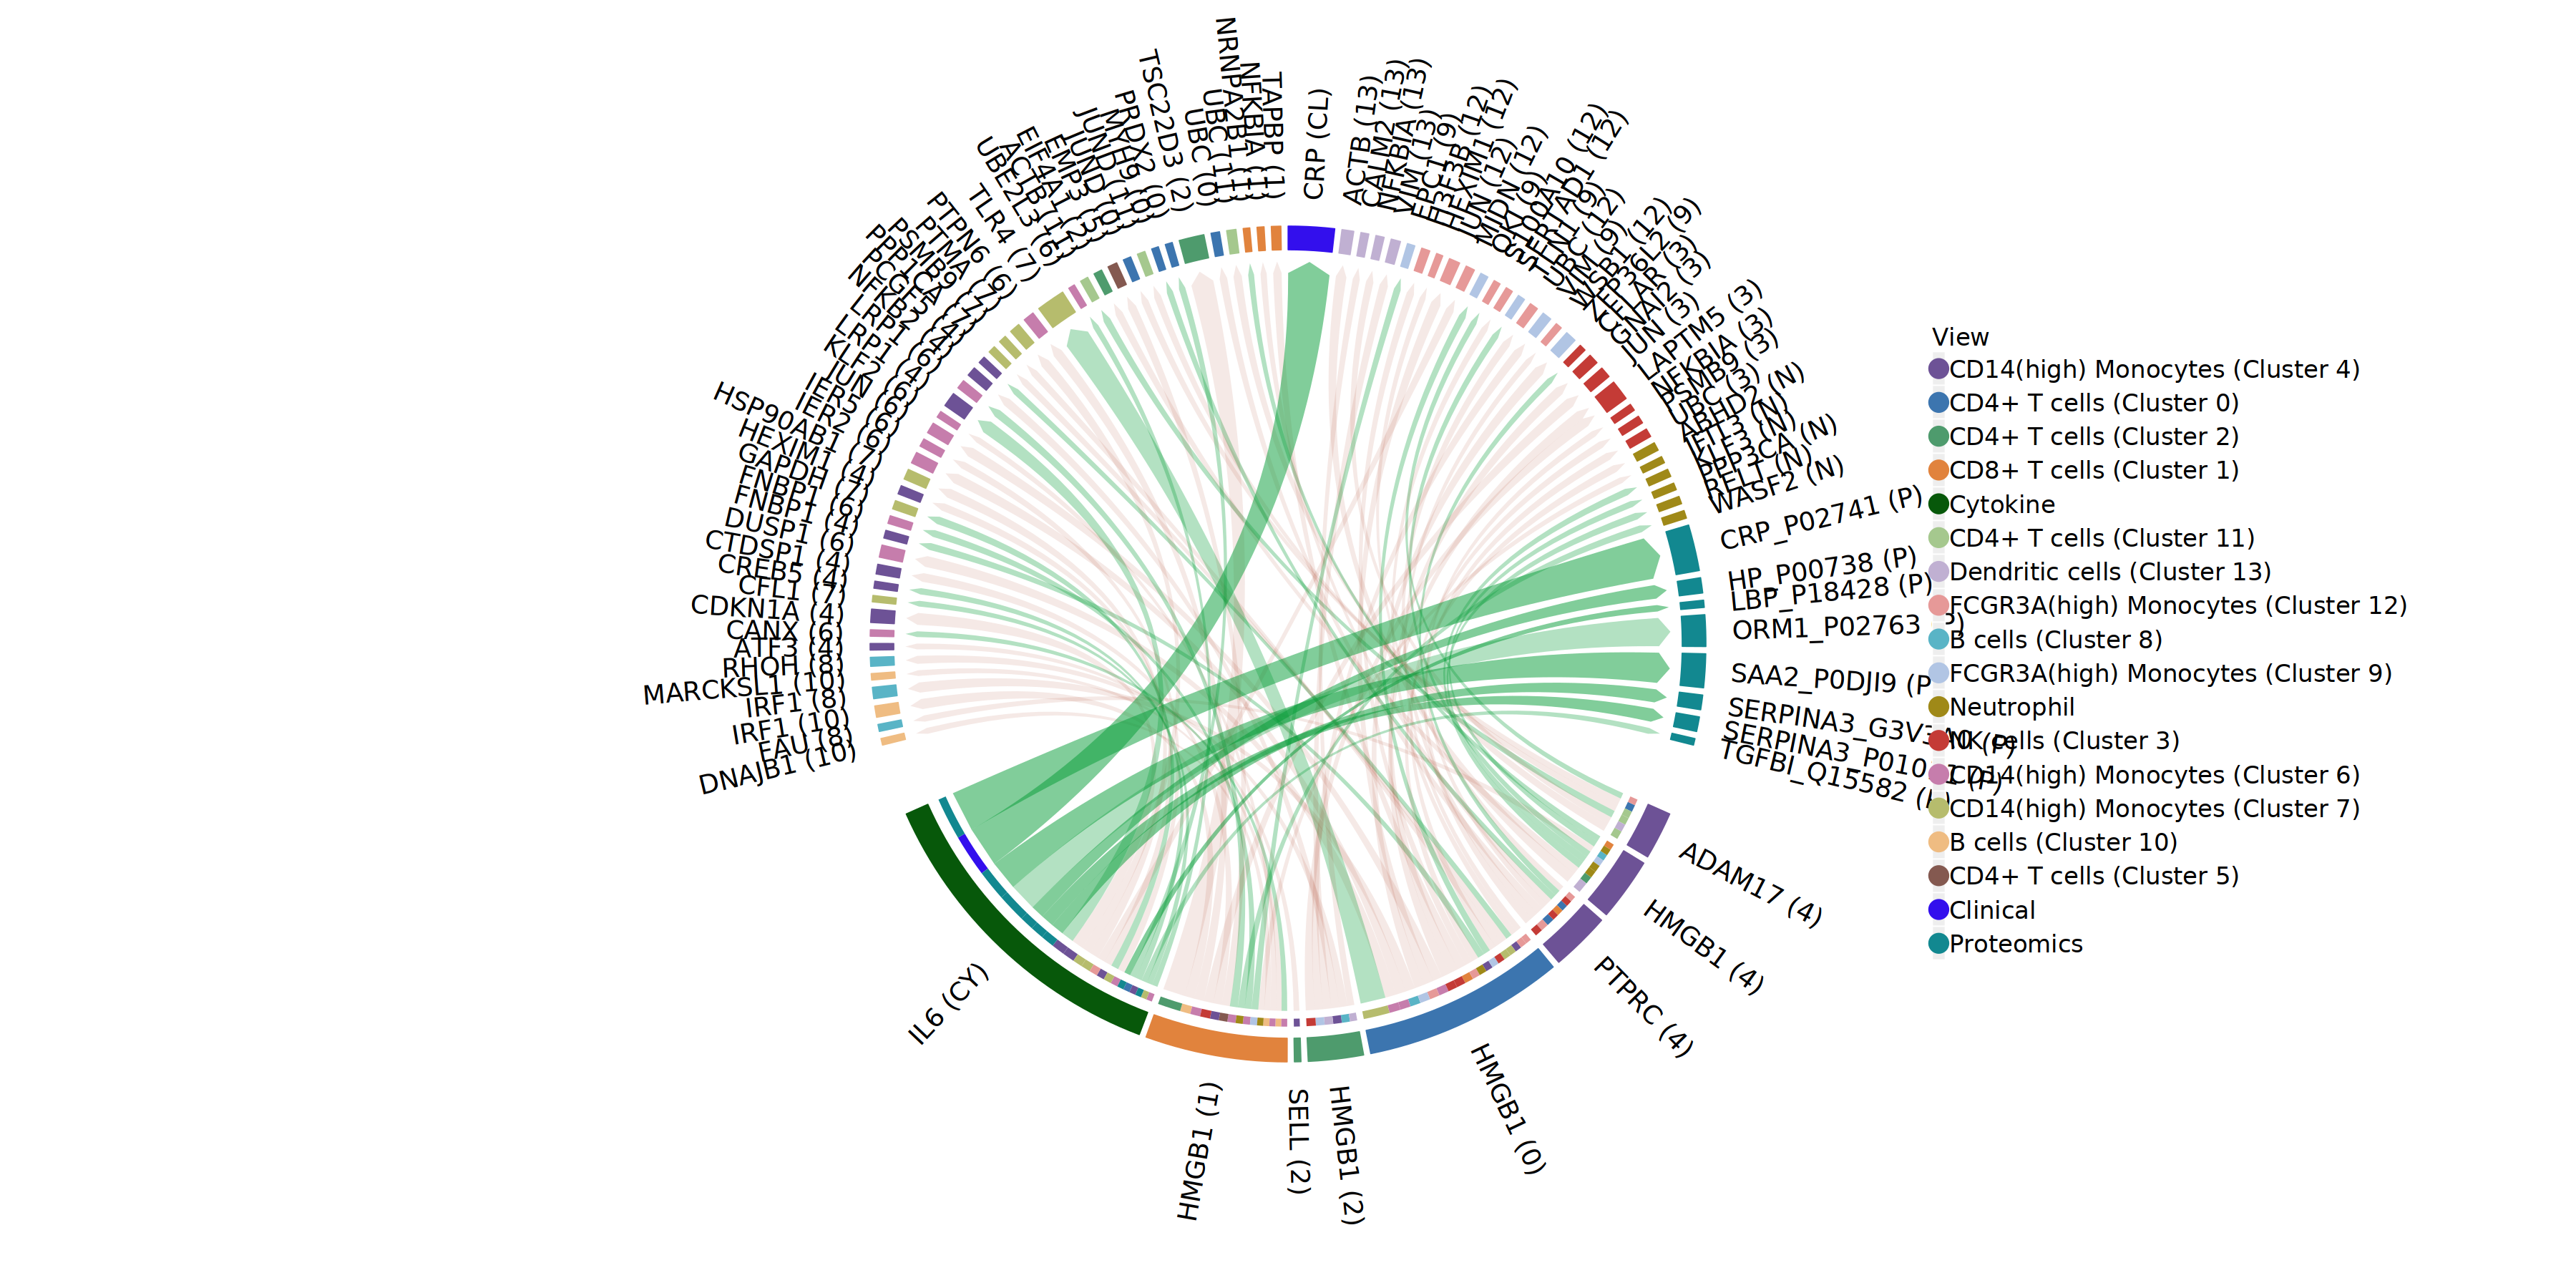

In [258]:
options(repr.plot.width=30, repr.plot.height=15)
chordDiagram(links_circle, directional = 1, order=order,link.sort = TRUE, link.decreasing = FALSE,col = col_mat, grid.col = grid_col, transparency = transparency, direction.type = c("diffHeight", "arrows"),  link.arr.type = "big.arrow", annotationTrack = c( "grid"), preAllocateTracks = 1, title(
    main = paste0('' ), cex.main = 1.5))
circos.trackPlotRegion(track.index = 1, panel.fun = function(x, y) {
  xlim = get.cell.meta.data("xlim")
  ylim = get.cell.meta.data("ylim")
  # sector.name = 
  circos.text(mean(xlim), ylim[1] + .1, text$text[text$variable == get.cell.meta.data("sector.index")], facing = "clockwise", niceFacing = TRUE, adj = c(0, 0.5),  cex = 1.8)
  #circos.axis(h = "top", labels.cex = 0.5, major.tick.length = 0.2, sector.index = get.cell.meta.data("sector.index"), track.index = 2)
}, bg.border = NA)
### Add legend
draw(lgd_list_vertical, x = unit(1.5, "snpc"), just = "left")

In [259]:
### Save the figure

In [260]:
options(repr.plot.width=30, repr.plot.height=15)
if(use_thres == 'quant_new'){
    pdf(paste0('figures/Supplementary_Figures/', figure_name, '_',  factor,'_', top_selection, '_',name, '_', top_variable_fraction, '_', cor_thres,'_' ,str_replace(reg_pot_thres_var, '%', ''),geneset_oi_selection, filter_samples, '.pdf'), 
        width = 6.5, 
        height = 6.5)
    }


chordDiagram(links_circle, directional = 1, 
             order=order,link.sort = TRUE, 
             link.decreasing = FALSE,
             col = col_mat, 
             grid.col = grid_col, 
             transparency = transparency, 
             direction.type = c("diffHeight", "arrows"),  
             link.arr.type = "big.arrow", 
             annotationTrack = c( "grid"), 
             preAllocateTracks = 1, 
             title(main = paste0('Top ', top_variable_fraction *100, '% ', geneset_oi_selection,' ',  str_replace(top_selection, 'top_', '') ), cex.main = 0.7))
circos.trackPlotRegion( track.height = 0.01, track.index = 1, panel.fun = function(x, y) {
  xlim = get.cell.meta.data("xlim")
  ylim = get.cell.meta.data("ylim")
  # sector.name = 
  circos.text(mean(xlim), ylim[1] + .1, text$text[text$variable == get.cell.meta.data("sector.index")], cex = 0.5, facing = "clockwise", niceFacing = TRUE, adj = c(0, 0.5))
  #circos.axis(h = "top", labels.cex = 0.5, major.tick.length = 0.2, sector.index = get.cell.meta.data("sector.index"), track.index = 2)
}, bg.border = NA)
### Add legend
draw(lgd_list_vertical, x = unit(1.5, "snpc"), just = "left")

dev.off()

png 
  2

In [261]:
top_variable_fraction

[1] 0.025

### Violin Plot lagged examples

In [484]:
head(data_long_normalized,2)

,X,sample_id,variable,value,type
,<int>,<chr>,<chr>,<dbl>,<chr>
1,1,k1,CK,-2.397022,clinical_data
2,2,k10,CK,NA,clinical_data


In [485]:
head(sample_data,2)

,X.1,sample_id,sample,id,measurement,library,id.y,name,read,pattern,⋯,meta_data,delta_ef_value_group,delta_ef_value,delta_ef_value_class,ef_classification_data,CK,CK_MB,Troponin,CRP,clinical_data
,<int>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<chr>,<dbl>,<chr>,<int>,<int>,<chr>,<dbl>,<chr>,<int>
1,1,k1,K1,1,TP0,L13,HTO_B0251,No-CCS-1,R2,5PNNNNNNNNNN(BC),⋯,1,NA,NA,NA,0,43,,0.013,0.4,1
2,2,k10,K10,10,TP0,L11,HTO_B0256,Ch-CCS-10,R2,5PNNNNNNNNNN(BC),⋯,1,NA,NA,NA,0,NA,,NA,0.2,1


In [486]:
correlation_var1 = c(   # ligand variable
         'cytokine_0_IL6__IL6',
    'cytokine_0_IL6__IL6',
       'cytokine_0_IL6__IL6',
     'cytokine_0_IL6__IL6',
    'cytokine_0_IL6__IL6',
    'cytokine_0_IL6__IL6',
    'single_cell_0_X0_T.cell.CD4__HMGB1',
    'single_cell_0_X4_Monocytes...CD14__ADAM17',
    'single_cell_0_X4_Monocytes...CD14__PTPRC',
'single_cell_0_X1_T.cell.CD8__CALM1',
'single_cell_0_X12_Monocytes...CD16_FCGR3A__PECAM1',
'cytokine_0_IL10__IL10',
'single_cell_0_X12_Monocytes...CD16_FCGR3A__PECAM1',
'cytokine_0_RANTES__CCL5',
'cytokine_0_LIF__LIF')
correlation_var2 = c(   # target variable
        'clinical_data_0_CRP',
    'proteomics_0_ORM1_P02763',
        'proteomics_0_SAA2_P0DJI9',
    'proteomics_0_HP_P00738',
    'proteomics_0_SERPINA3_P01011',
    'proteomics_0_SERPINA3_G3V3A0',
    'single_cell_0_X7_Monocytes...CD14__TLR4',
    'single_cell_0_X11_T.cell.CD4__JUND',
   'single_cell_0_X3_NK__UBC',
    'single_cell_0_X3_NK__JUNB',
'single_cell_0_X0_T.cell.CD4__LEF1',
'single_cell_0_X0_T.cell.CD4__IKZF1',
'single_cell_0_X1_T.cell.CD8__UBC',
'single_cell_0_X4_Monocytes...CD14__GADD45B',
'single_cell_0_X0_T.cell.CD4__S100A10')


In [487]:
### select which of the features of the list above should be visualized

In [488]:
pair = 1

In [489]:
feature_1 = correlation_var1[pair]
feature_2 = correlation_var2[pair]

In [490]:
correlation_var2[pair]

[1] "clinical_data_0_CRP"

In [491]:
feature_2

[1] "clinical_data_0_CRP"

In [492]:
### Get features from data

In [493]:
plot_data = data_long_normalized[data_long_normalized$variable %in% c(str_replace(feature_1, '.*_0_', ''), str_replace(feature_2, '.*_0_', '')),]

In [494]:
head(plot_data,2)

,X,sample_id,variable,value,type
,<int>,<chr>,<chr>,<dbl>,<chr>
257,257,k1,CRP,-0.3186394,clinical_data
258,258,k10,CRP,-0.8871466,clinical_data


In [495]:
plot_data = plot_data %>% dcast(sample_id ~ variable, value.var = 'value')

In [496]:
plot_data = plot_data[,c('sample_id', str_replace(feature_1, '.*_0_', ''),  str_replace(feature_2, '.*_0_', ''))]

In [497]:
head(plot_data,2)

,sample_id,IL6__IL6,CRP
,<chr>,<dbl>,<dbl>
1,k1,-0.7443035,-0.3186394
2,k10,-1.0725689,-0.8871466


In [498]:
colnames(plot_data) = c('sample_id', 'var1', 'var2')

In [499]:
plot_data = rbind(plot_data, data.frame(sample_id = 'xxx', var1 = 0, var2 = 0))

In [500]:
nrow(plot_data)

[1] 129

In [501]:
plot_data = merge(plot_data, unique(sample_data[,c('sample_id', 'measurement', 'classification')]), all.x = TRUE)

In [502]:
nrow(plot_data)

[1] 129

In [503]:
### Set missing measurements to NA

In [504]:
plot_data$measurement[is.na(plot_data$measurement)] = 'TP0_NA'

In [505]:
head(plot_data,2)

,sample_id,var1,var2,measurement,classification
,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,k1,-0.7443035,-0.3186394,TP0,vollstaendiger_ausschluss
2,k10,-1.0725689,-0.8871466,TP0,ccs


In [506]:
### Remove control/ TP0 measurments (not mapped in lagged variables)

In [507]:
plot_data = plot_data[plot_data$measurement != 'TP0',]

In [508]:
feature_1

[1] "cytokine_0_IL6__IL6"

In [509]:
# Adjust text descriptions of violin
plot_correlation = ligand_target_correlation[(ligand_target_correlation$Ligand == feature_1) &(ligand_target_correlation$Target == feature_2),] 
violin1_title = paste0(plot_correlation$Ligand_Gene, ' (', plot_correlation$Ligand_Cluster_Number, ')')
violin2_title= xlab(paste0(plot_correlation$Target_Gene, ' (', plot_correlation$Target_Cluster_Number, ')'))

In [510]:
## Filter only acs_w_o_infection for violin
filter_samples = c('acs_w_o_infection', NA)

In [511]:
figure_name = 'SUPP12_Lagged_Violin'

Warning message:
“Removed 2 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Removed 2 rows containing non-finite values (`stat_sina()`).”
Warning message:
“Removed 11 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Removed 11 rows containing non-finite values (`stat_sina()`).”


png 
  2

Warning message:
“Removed 2 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Removed 2 rows containing non-finite values (`stat_sina()`).”
Warning message:
“Removed 11 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Removed 11 rows containing non-finite values (`stat_sina()`).”


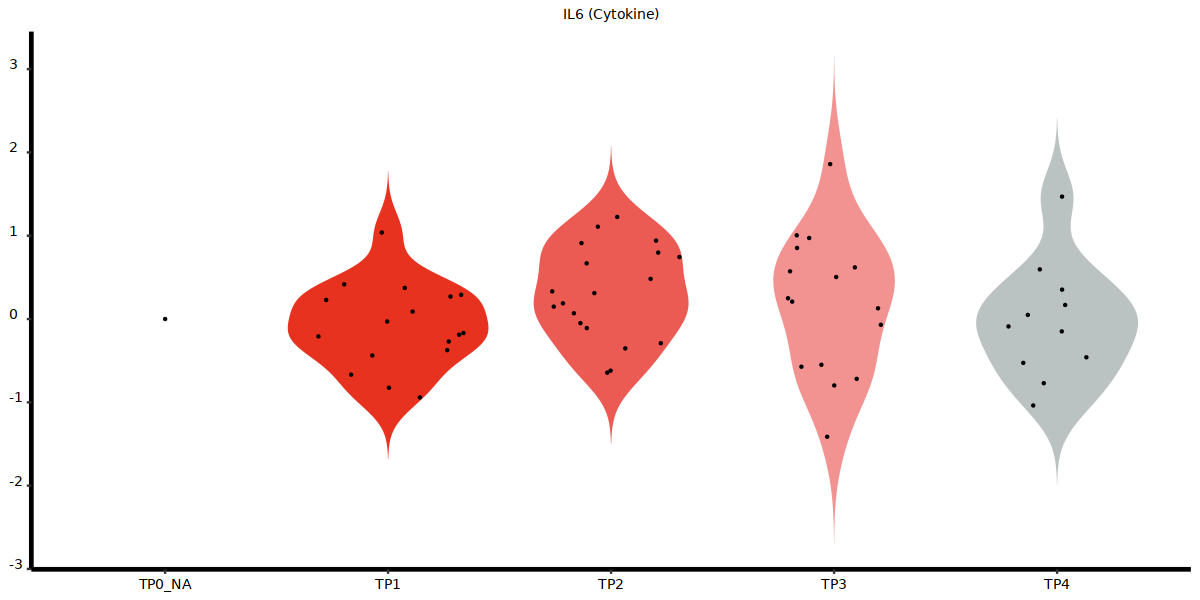

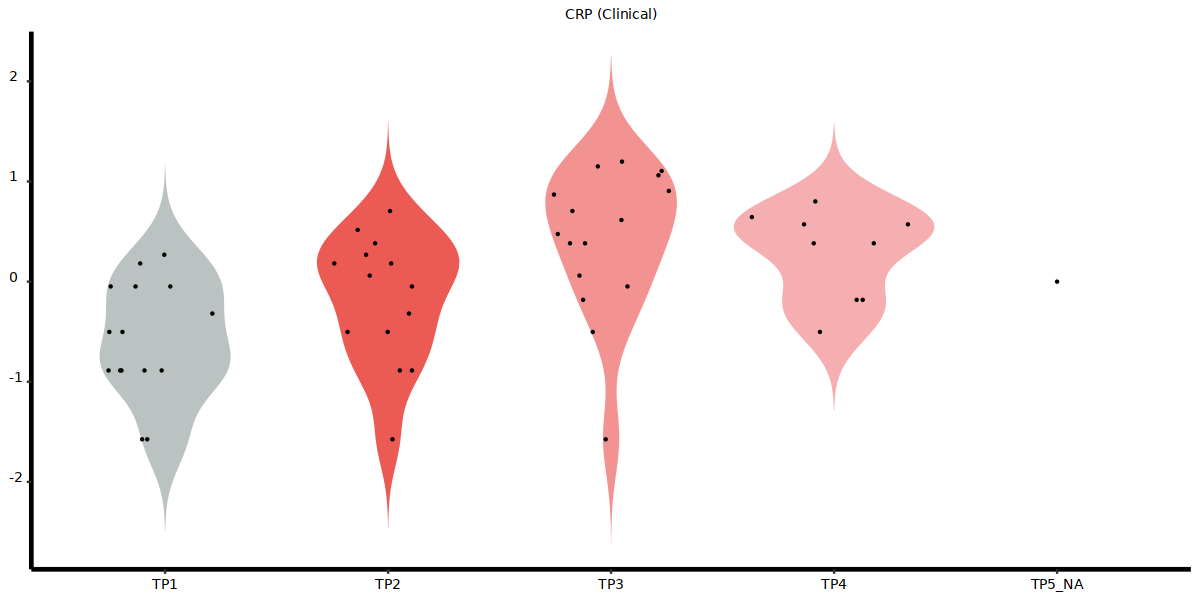

In [512]:
options(repr.plot.width=10, repr.plot.height=5)
pdf(paste0('figures/Supplementary_Figures/', figure_name,feature_1, filter_samples, '.pdf'), width =  10, height =5)

## Plot for variable 1
violin_plot = ggplot(plot_data[plot_data$classification %in% filter_samples,], aes(x= measurement, y=var1, fill = measurement)) + 
        geom_violin(trim=FALSE, size = 0.01)+ geom_sina(alpha=1, size = 0.2)  +
        plot_config +
        theme(strip.background = element_rect(color="black", fill="white", linetype="solid"), strip.placement = "outside", strip.switch.pad.grid = unit(0.1, "cm"), axis.title.y = element_blank(), axis.title.x = element_blank(), panel.spacing = unit(0.1, "cm")) + 
        ccs_tp_fill_ligand + theme(legend.position="none") + ggtitle(violin1_title)  #+  stat_compare_means(aes(group = measurement), comparisons = list(c('TP1', 'TP2'), c('TP2', 'TP3'), c('TP1', 'TP3')), size = 2 ,method = 't.test')


## Plot for variable 2
plot_data$measurement[plot_data$measurement == 'TP0_NA'] = 'TP5_NA'
violin_plot2 = ggplot(plot_data[(plot_data$measurement %in% c('TP1', 'TP2', 'TP3', 'TP4', 'TP5_NA')) & (plot_data$classification %in% filter_samples) ,], aes(x=measurement, y= var2, fill = measurement)) + 
        geom_violin(trim=FALSE, size = 0.01)+ geom_sina(alpha=1, size = 0.2)  +
        plot_config +
        theme(strip.background = element_rect(color="black", fill="white", linetype="solid"), strip.placement = "outside", strip.switch.pad.grid = unit(0.1, "cm"), axis.title.y = element_blank(), axis.title.x = element_blank(), panel.spacing = unit(0.1, "cm")) + 
        ccs_tp_fill_target + theme(legend.position="none") + ggtitle(violin2_title)  #+  stat_compare_means(aes(group = measurement), comparisons = list(c('TP2', 'TP3'), c('TP3', 'TP4'), c('TP2', 'TP4')), size = 2 ,method = 't.test')


print(violin_plot)
print(violin_plot2)

dev.off()

print(violin_plot)
print(violin_plot2)


In [513]:
unique(plot_data$measurement)

[1] "TP1"    "TP2"    "TP3"    "TP4"    "TP5_NA"

In [517]:
#head(plot_data)

### Scatterplot for single correlations 

In [518]:
head(data_long,2)

,X,sample_id,type,variable,value,config
,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>
390424,390424,m1.1,single_cell,X0_T.cell.CD4__SSU72,0.5662586,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-
390425,390425,m1.1,single_cell,X0_T.cell.CD4__PARK7,0.9050330,FALSE-FALSE-TRUE-0.2-FALSE-TRUE-


In [519]:
head(ligand_target_correlation,2)

V1,Ligand_Gene,Target_Gene,cluster,Ligand,Target,correlation,Target_Type,Ligand_Type,regulatory_potential,regulatory_potential_scaled,Target_Cell_Type,Ligand_Cell_Type,Ligand_Cluster_Text,Target_Cluster_Text,Ligand_Cluster_Number,Target_Cluster_Number
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,ADAM17,A1BG,proteomics,single_cell_0_X4_Monocytes...CD14__ADAM17,proteomics_0_A1BG_M0R009,0.08571429,proteomics,single_cell_0_X4_Monocytes...CD14,0.0004622894,0.01667641,Proteomics,CD14(high) Monocytes,CD14(high) Monocytes (Cluster 4),Proteomics,4,Proteomics
2,ADAM17,A1BG,proteomics,single_cell_0_X6_Monocytes...CD14__ADAM17,proteomics_0_A1BG_M0R009,-0.09713251,proteomics,single_cell_0_X6_Monocytes...CD14,0.0004622894,0.01667641,Proteomics,CD14(high) Monocytes,CD14(high) Monocytes (Cluster 6),Proteomics,6,Proteomics


In [520]:
### Filter on variables to plot selected above

In [521]:
#plot_data = data_long[(data_long$variable %in% c(str_replace(feature_1, '.*_0_', ''), str_replace(feature_2, '.*_0_', ''))),]
plot_data = data_long_normalized[(data_long_normalized$variable %in% c(str_replace(feature_1, '.*_0_', ''), str_replace(feature_2, '.*_0_', ''))),]

In [522]:
plot_data = plot_data %>% dcast(sample_id ~ variable, value.var = 'value')

In [523]:
head(plot_data,2)

,sample_id,CRP,IL6__IL6
,<chr>,<dbl>,<dbl>
1,k1,-0.3186394,-0.7443035
2,k10,-0.8871466,-1.0725689


In [524]:
### Calculate correlation between selected lagged variables

In [525]:
plot_correlation = ligand_target_correlation[(ligand_target_correlation$Ligand == feature_1) &(ligand_target_correlation$Target == feature_2),] 

In [526]:
head(plot_correlation,2)

V1,Ligand_Gene,Target_Gene,cluster,Ligand,Target,correlation,Target_Type,Ligand_Type,regulatory_potential,regulatory_potential_scaled,Target_Cell_Type,Ligand_Cell_Type,Ligand_Cluster_Text,Target_Cluster_Text,Ligand_Cluster_Number,Target_Cluster_Number
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2159962,IL6,CRP,clinical_data,cytokine_0_IL6__IL6,clinical_data_0_CRP,0.7678435,clinical_data,cytokine,0.008810596,0.3178292,Clinical,Cytokine,Cytokine,Clinical,Cytokine,Clinical


In [527]:
### Lag the target variable
plot_data$tp = str_replace(plot_data$sample_id, '.*\\.', '')
plot_data$sample = str_replace(plot_data$sample_id, '\\..*', '')

In [528]:
## lagged target
plot_data_lag = plot_data[,c(str_replace(feature_2, '.*_0_', ''), 'tp', 'sample')]
plot_data_lag$tp = str_replace(plot_data_lag$tp, '1', '0')
plot_data_lag$tp = str_replace(plot_data_lag$tp, '2', '1')
plot_data_lag$tp = str_replace(plot_data_lag$tp, '3', '2')
plot_data_lag$tp = str_replace(plot_data_lag$tp, '4', '3')
plot_data_lag$sample_id = paste0(plot_data_lag$sample, '.', plot_data_lag$tp)

In [529]:
plot_data[,str_replace(feature_2, '.*_0_', '')] = NULL

In [530]:
head(plot_data_lag,2)

,CRP,tp,sample,sample_id
,<dbl>,<chr>,<chr>,<chr>
1,-0.3186394,k0,k1,k1.k0
2,-0.8871466,k00,k10,k10.k00


In [531]:
## Merge lagged variable

In [532]:
plot_data = merge(plot_data, plot_data_lag)

In [533]:
nrow(plot_data)

[1] 66

In [534]:
head(plot_data,2)

,sample_id,tp,sample,IL6__IL6,CRP
,<chr>,<chr>,<chr>,<dbl>,<dbl>
1,m10.1,1,m10,0.7705986,NA
2,m10.2,2,m10,1.7580432,1.768825


In [535]:
## correlation between lagged variable and target

In [536]:
cor(plot_data[,4], plot_data[,5], use = 'complete.obs', method = 'spearman')

[1] 0.7678435

In [537]:
### Remove columns and rename

In [538]:
plot_data$tp = NULL
plot_data$sample = NULL

In [539]:
colnames(plot_data ) = c('sample_id', 'var1', 'var2')

In [540]:
# Specific Text Descriptions:
ylabel = ylab(paste0(plot_correlation$Ligand_Gene, ' (', plot_correlation$Ligand_Cluster_Number, ')'))
xlabel = xlab(paste0(plot_correlation$Target_Gene, ' (', plot_correlation$Target_Cluster_Number, ')'))

In [541]:
# Add sanoke data for measurement information

In [542]:
plot_data = merge(plot_data, unique(sample_data[,c('sample_id', 'measurement', 'group')]))

In [543]:
nrow(plot_data)

[1] 66

In [544]:
unique(plot_data$measurement)

[1] "TP1" "TP2" "TP3"

In [545]:
head(plot_data,2)

,sample_id,var1,var2,measurement,group
,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,m10.1,0.7705986,NA,TP1,acs
2,m10.2,1.7580432,1.768825,TP2,acs


In [546]:
plot_data$class = plot_data$group

In [547]:
plot_data$measurement2 = plot_data$measurement

In [548]:
plot_data$measurement2[plot_data$class %in% c( 'ccs')] = 'CCS'
plot_data$measurement2[plot_data$class %in% c('no_ccs')] = 'No CCS'

In [549]:
unique(plot_data$measurement2)

[1] "TP1" "TP2" "TP3"

In [550]:
head(plot_data,2)

,sample_id,var1,var2,measurement,group,class,measurement2
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,m10.1,0.7705986,NA,TP1,acs,acs,TP1
2,m10.2,1.7580432,1.768825,TP2,acs,acs,TP2


In [551]:
### Generate the scatter plot

In [552]:
figure_name = "FIG11_LAG_Scatter_"

In [553]:
# Sizes of the plot
width_par = 1.3
height_par = 1.6

In [554]:
if(plot_correlation$correlation > 0){
    annotations <- data.frame(
      xpos = c(-Inf), ypos =  c(-Inf),
      annotateText = paste0('cor = ', round(plot_correlation$correlation,2)),
      hjustvar = c(-0.9), #-0.1
      vjustvar = c(-1.4))
    }

if(plot_correlation$correlation < 0){
    annotations <- data.frame(
      xpos = c(-Inf), ypos =  c(-Inf),
      annotateText = paste0('cor = ', round(plot_correlation$correlation,2)),
      hjustvar = c(-0.1), #-0.1
      vjustvar = c(-1.5))
    }

In [555]:
head(plot_data,2)

,sample_id,var1,var2,measurement,group,class,measurement2
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,m10.1,0.7705986,NA,TP1,acs,acs,TP1
2,m10.2,1.7580432,1.768825,TP2,acs,acs,TP2


In [556]:
if(plot_correlation$correlation < 0){

    scatter = ggplot(plot_data, aes(x=var2, y=var1)) + # removed color; for adding: color = measurement2
      geom_point(size=0.2) +
      geom_text(data = annotations, aes(x = xpos, y = ypos, hjust = hjustvar, vjust = vjustvar, label = annotateText), size = 2, color = 'red')+
      plot_config + ccs_tp_color + theme(axis.text.x = element_text(angle = 90), legend.position = 'none') +
      xlabel +
      ylabel 
    }

if(plot_correlation$correlation > 0){
        scatter = ggplot(plot_data, aes(x=var2, y=var1)) +  # removed color; for adding: color = measurement2
      geom_point(size=0.2) +
      geom_text(data = annotations, aes(x = xpos, y = ypos, hjust = hjustvar, vjust = vjustvar, label = annotateText), size = 2, color = 'darkgreen')+
      plot_config + ccs_tp_color + theme(axis.text.x = element_text(angle = 90), legend.position = 'none') +
      xlabel +
      ylabel
    }

In [557]:
## Save the plot

In [558]:
pdf(paste0('figures/Final_Figures/', figure_name,plot_correlation$Ligand_Gene, plot_correlation$Target_Gene, filter_samples, '.pdf'), width =width_par, height =height_par)
print(scatter)
dev.off()
    

Warning message:
“Removed 13 rows containing missing values (`geom_point()`).”


png 
  2

In [559]:
### save all in one combined pdf

In [560]:
figure_name = "SUPP12_Lagged_"

In [561]:
options(repr.plot.width=10, repr.plot.height=5)
pdf(paste0('figures/Supplementary_Figures/', figure_name,feature_1, '_TG_', feature_2, filter_samples, '.pdf'), width =  4.5, height =4)
combined = ggarrange(violin_plot,  scatter, violin_plot2, 
          ncol = 2, nrow = 2)
print(combined)
dev.off()


Warning message:
“Removed 2 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Removed 2 rows containing non-finite values (`stat_sina()`).”
Warning message:
“Removed 13 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 11 rows containing non-finite values (`stat_ydensity()`).”
Warning message:
“Groups with fewer than two data points have been dropped.”
Warning message:
“Removed 11 rows containing non-finite values (`stat_sina()`).”


png 
  2

In [562]:
head(plot_data,2)

,sample_id,var1,var2,measurement,group,class,measurement2
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,m10.1,0.7705986,NA,TP1,acs,acs,TP1
2,m10.2,1.7580432,1.768825,TP2,acs,acs,TP2
